In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import copy
import shutil
import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import enum
from skimage.transform import resize
import time
from scipy import stats
import random
from IPython import display
import scipy.io
import cv2
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as A

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
aug = A.Compose([      
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.4),
    A.Transpose(p=0.5),          
    A.RandomRotate90(p=0.5),
    # A.GridDistortion(p=0.3),
    # A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
    # A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.RandomBrightnessContrast(p=0.4),    
    A.RandomGamma(p=0.5),
    ])

class DehazeDataset(Dataset):
  def __init__(self, img_paths=None, mask_paths=None, a=True):
    self.a = a
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    assert len(self.img_paths) == len(self.mask_paths)
    self.images = len(self.img_paths) #list all the files present in that folder...
    self.transform = aug
  
  def __len__(self):
    return len(self.img_paths) #length of dataset

  def Lowpass(self, img):
    temp = img.copy()
    dst = cv2.GaussianBlur(temp,(5,5),cv2.BORDER_DEFAULT) 
    return dst
  
  def Highpass(self, img):
    temp = img.copy()
    dst = cv2.GaussianBlur(temp,(3,3),0) 
    source_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    dest = cv2.Laplacian(source_gray, cv2.CV_16S, ksize=3)
    abs_dest = cv2.convertScaleAbs(dest)
    return abs_dest
  
  def __getitem__(self, index):
    img_path = self.img_paths[index]
    mask_path = self.mask_paths[index]

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    if self.a:
      augment = self.transform(image = image, mask=mask)
      image = augment['image']
      mask = augment['mask']

    lowpass = self.Lowpass(mask)
    highpass = self.Highpass(mask)
    
    image = image.astype(np.float32)
    image = image/255.0
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)

    lowpass = lowpass.astype(np.float32)
    lowpass = lowpass/255.0
    lowpass = torch.from_numpy(lowpass)
    lowpass = lowpass.permute(2,0,1)

    highpass = highpass.astype(np.float32)
    highpass = highpass[:,:,np.newaxis]
    highpass = highpass/255.0
    highpass = torch.from_numpy(highpass)
    highpass = highpass.permute(2,0,1)

    mask = mask.astype(np.float32)
    mask = mask/255.0
    mask = torch.from_numpy(mask)
    mask = mask.permute(2,0,1)

    return image, lowpass, highpass, mask

In [ ]:
class DehazeDataset(Dataset):
  def __init__(self, img_paths=None, mask_paths=None, a=True):
    self.a = a
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    assert len(self.img_paths) == len(self.mask_paths)
    self.images = len(self.img_paths) #list all the files present in that folder...
    self.transform = aug
  
  def __len__(self):
    return len(self.img_paths) #length of dataset

  def Lowpass(self, img):
    temp = img.copy()
    dst = cv2.GaussianBlur(temp,(5,5),cv2.BORDER_DEFAULT) 
    return dst
  
  def Highpass(self, img):
    temp = img.copy()
    dst = cv2.GaussianBlur(temp, (3,3) ,0) 
    source_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    dest = cv2.Laplacian(source_gray, cv2.CV_16S, ksize=3)
    abs_dest = cv2.convertScaleAbs(dest)
    return abs_dest
  
  def __getitem__(self, index):
    img_path = self.img_paths[index]
    mask_path = self.mask_paths[index]

    image = cv2.imread(img_path)
    image = cv2.resize(image,(1024,1024))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask,(1024,1024))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2YCrCb)
    

    if self.a:
      augment = self.transform(image = image, mask=mask)
      image = augment['image']
      mask = augment['mask']

    lowpass = self.Lowpass(mask)
    highpass = self.Highpass(mask)
    
    image = image.astype(np.float32)
    image = image/255.0
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)

    lowpass = lowpass.astype(np.float32)
    lowpass = lowpass/255.0
    lowpass = torch.from_numpy(lowpass)
    lowpass = lowpass.permute(2,0,1)

    highpass = highpass.astype(np.float32)
    highpass = highpass[:,:,np.newaxis]
    highpass = highpass/255.0
    highpass = torch.from_numpy(highpass)
    highpass = highpass.permute(2,0,1)

    mask = mask.astype(np.float32)
    mask = mask/255.0
    mask = torch.from_numpy(mask)
    mask = mask.permute(2,0,1)

    return image, lowpass, highpass, mask

In [ ]:
import math
def psnr(pred, gt):
    pred=pred.clamp(0,1).detach().cpu().numpy()
    gt=gt.clamp(0,1).detach().cpu().numpy()
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10( 1.0 / rmse)

In [ ]:
from math import exp
from torch.autograd import Variable
import torch.nn.functional as F3

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F3.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F3.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F3.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F3.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F3.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
class backbone(nn.Module):
  def __init__(self):
    super(backbone, self).__init__()

    model = models.efficientnet_b6(pretrained=True)
    m1 = list(model.features.children())
    self.l1 = nn.Sequential(*list(model.features.children())[:2])
    self.l2 = nn.Sequential(*list(model.features[2][:3]))
    self.l3 = nn.Sequential(*list(model.features[3][:4]))
    self.l4 = nn.Sequential(*list(model.features[4][:4]))
    self.l5 = nn.Sequential(*list(model.features[5][:2]))
    self.l6 = nn.Sequential(*list(model.features[6][:2]))

  def forward(self, x):
    x1 = self.l1(x)
    x2 = self.l2(x1)
    x3 = self.l3(x2)
    x4 = self.l4(x3)
    x5 = self.l5(x4)
    x6 = self.l6(x5)
    return [x1, x2, x3, x5, x6]

class ConvbnGelu(nn.Module):
  def __init__(self, inchannels, outchannels, kernel_size=3, stride=1, padding=1):
    super(ConvbnGelu, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(inchannels, outchannels, kernel_size, stride, padding),
        nn.GELU(),
        nn.BatchNorm2d(outchannels)
    )
  def forward(self, x):
    return self.conv(x)

class SEAttention(nn.Module):   #it gives channel attention
    def __init__(self, in_channels, reduced_dim=16):  #input_shape ---> output_shape
        super(SEAttention, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResidualBlock, self).__init__()

        self.c1 = ConvbnGelu(inchannels=in_c, outchannels=out_c)
        self.c2 = ConvbnGelu(inchannels=out_c, outchannels=out_c)
        self.c3 = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_c)
        self.se = SEAttention(in_channels=out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # print(x.shape)
        x1 = self.c1(x)
        x2 = self.c2(x1)
        x3 = self.c3(x)
        x3 = self.bn3(x3)
        x3 = self.se(x3)
        x4 = x2 + x3
        x4 = self.relu(x4)
        return x4

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(EncoderBlock, self).__init__()

        self.r1 = ResidualBlock(in_c, out_c)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.r1(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_c, skip_c, out_c):
        super(DecoderBlock, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1)
        self.r1 = ResidualBlock(skip_c+out_c, out_c)
        # self.r2 = ResidualBlock(out_c, out_c)

    def forward(self, x, s):
        x = self.upsample(x)
        x = torch.cat([x, s], axis=1)
        x = self.r1(x)
        # x = self.r2(x)
        return x

class GBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(GBlock, self).__init__()

        self.c = nn.Conv2d(in_c+in_c, out_c, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x1, x2, x3):
        x = torch.cat([x1, x2], axis=1)
        x = self.c(x)
        x = self.sig(x)
        x = x * x3
        return x

class DehazeModel(nn.Module):
  def __init__(self):
    super(DehazeModel, self).__init__()
    
    self.backbone = backbone()

    self.ld1 = DecoderBlock(in_c=344, skip_c=200, out_c=256)
    self.hd1 = DecoderBlock(in_c=344, skip_c=200, out_c=256)
    self.id1 = DecoderBlock(in_c=344, skip_c=200, out_c=256)
    self.g1 = GBlock(in_c=256, out_c=256)

    self.ld2 = DecoderBlock(in_c=256, skip_c=72, out_c=128)
    self.hd2 = DecoderBlock(in_c=256, skip_c=72, out_c=128)
    self.id2 = DecoderBlock(in_c=256, skip_c=72, out_c=128)
    self.g2 = GBlock(in_c=128, out_c=128)

    self.ld3 = DecoderBlock(in_c=128, skip_c=40, out_c=64)
    self.hd3 = DecoderBlock(in_c=128, skip_c=40, out_c=64)
    self.id3 = DecoderBlock(in_c=128, skip_c=40, out_c=64)
    self.g3 = GBlock(in_c=64, out_c=64)

    self.ld4 = DecoderBlock(in_c=64, skip_c=32, out_c=32)
    self.hd4 = DecoderBlock(in_c=64, skip_c=32, out_c=32)
    self.id4 = DecoderBlock(in_c=64, skip_c=32, out_c=32)
    self.g4 = GBlock(in_c=32, out_c=32)

    self.ld5 =  nn.Sequential(  nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
                                nn.Conv2d(32, 3, 3, 1, 1),
                                nn.Tanh()
                            )#ResidualBlock(in_c=32, out_c=3, last=True)
    self.hd5 = nn.Sequential(   nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
                                nn.Conv2d(32, 1, 3, 1, 1),
                                nn.Tanh()
                            )#ResidualBlock(in_c=32, out_c=1, last=True)
    self.id5 = nn.Sequential(   nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
                                nn.Conv2d(32, 3, 3, 1, 1),
                                nn.Tanh()
                            )#ResidualBlock(in_c=32, out_c=3, last=True)

  def forward(self, x):

    x1, x2, x3, x4, x5 = self.backbone(x)

    """block 1"""
    l1 = self.ld1(x5,x4)  
    h1 = self.hd1(x5,x4)  
    i1 = self.id1(x5,x4) 
    i1 = self.g1(l1,h1,i1)

    """block 2"""
    l2 = self.ld2(l1,x3)  
    h2 = self.hd2(h1,x3)  
    i2 = self.id2(i1,x3) 
    i2 = self.g2(l2,h2,i2)

    """block 3"""
    l3 = self.ld3(l2,x2)  
    h3 = self.hd3(h2,x2)  
    i3 = self.id3(i2,x2) 
    i3 = self.g3(l3,h3,i3)

    """block 4"""
    l4 = self.ld4(l3,x1)  
    h4 = self.hd4(h3,x1)  
    i4 = self.id4(i3,x1) 
    i4 = self.g4(l4,h4,i4)

    """block 5 [last block]"""
    l5 = self.ld5(l4)
    h5 = self.hd5(h4)
    i5 = self.id5(i4)

    return l5,h5,i5

# I haze

In [ ]:
x_train = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/I HAZE/WITHOUT RESIZE/TRAIN/HAZY/*.png')
y_train = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/I HAZE/WITHOUT RESIZE/TRAIN/GT/*.png')
x_test = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/O HAZE/# O-HAZY NTIRE 2018/hazy/*.jpg')
y_test = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/O HAZE/# O-HAZY NTIRE 2018/GT/*.jpg')

x_train = sorted(x_train)
y_train = sorted(y_train)
x_test = sorted(x_test)
y_test = sorted(y_test)

print(len(x_train), len(x_test), len(y_train), len(y_test))

1500 43 1500 43


In [ ]:
train_ds = DehazeDataset(
    img_paths=x_test,
    mask_paths=y_test,
    a = False
)
train_loader = DataLoader(
    train_ds,
    batch_size=1,
    num_workers=4,
    shuffle=False,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


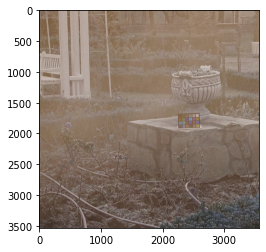

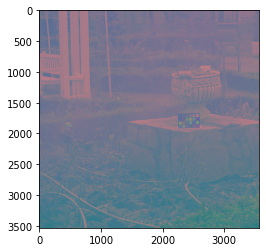

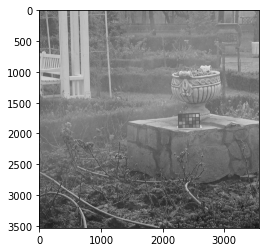

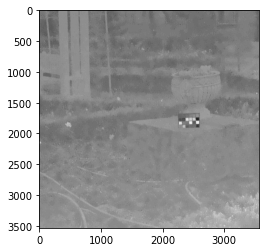

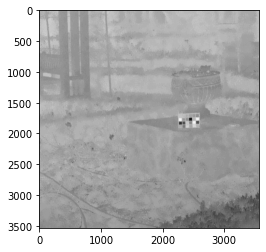

In [ ]:
mask = cv2.imread(x_test[33])
plt.imshow(mask)
plt.imsave("hazy_rgb.png",cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2YCrCb)
plt.imsave("hazy_ycbcr.png",mask)
plt.imshow(mask)
plt.show()
Y = mask[:,:,0] 
Cb = mask[:,:,1] 
Cr = mask[:,:,2] 
plt.imshow(Y,cmap='gray')
plt.imsave("hazy_Y.png",Y,cmap='gray')
plt.show()
plt.imshow(Cb,cmap='gray')
plt.imsave("hazy_cb.png",Cb,cmap='gray')
plt.show()
plt.imshow(Cr,cmap='gray')
plt.imsave("hazy_cr.png",Cr,cmap='gray')
plt.show()

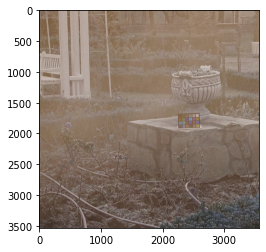

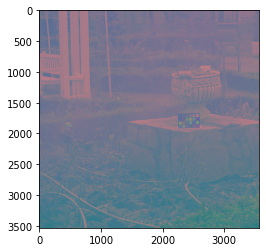

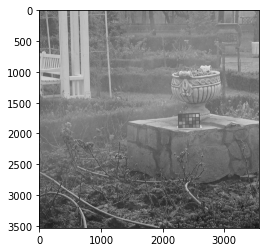

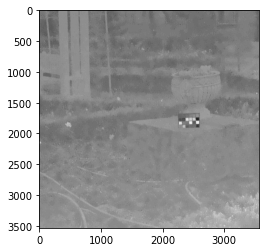

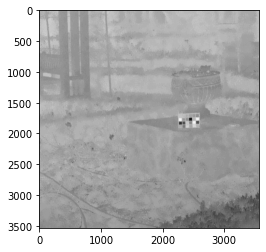

In [ ]:
mask = cv2.imread(x_test[33])
plt.imshow(mask)
plt.show()
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2YCrCb)
plt.imshow(mask)
plt.show()
Y = mask[:,:,0] 
Cb = mask[:,:,1] 
Cr = mask[:,:,2] 
plt.imshow(Y,cmap='gray')
plt.show()
plt.imshow(Cb,cmap='gray')
plt.show()
plt.imshow(Cr,cmap='gray')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


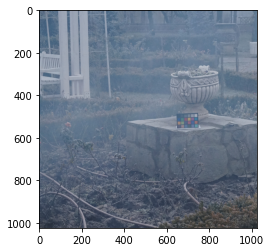

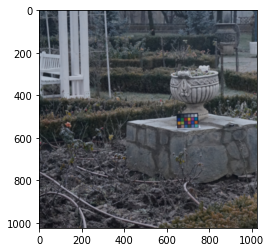

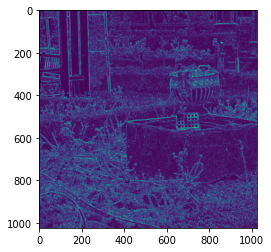

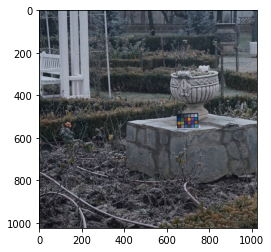

(1024, 1024, 3) (1024, 1024, 3) (1024, 1024, 1) (1024, 1024, 3)
34
35
36
37
38
39
40
41
42


In [ ]:
for i, data in enumerate(train_loader):
    print(i)
    if i == 33:
      img = data[0]
      img = img[0].permute(1,2,0).numpy()
      plt.imsave('/content/input_image.png', img)
      plt.imshow(img)
      plt.show()
      lp = data[1]
      lp = lp[0].permute(1,2,0).numpy()
      plt.imsave('/content/low_pass.png', lp)
      plt.imshow(lp)
      plt.show()
      hp = data[2]
      hp = hp[0].permute(1,2,0).numpy()
      plt.imsave('/content/high_pass.png', hp[:,:,0])
      plt.imshow(hp[:,:,0])
      plt.show()
      mask = data[3]
      mask = mask[0].permute(1,2,0).numpy()
      plt.imsave('/content/ground_truth.png', mask)
      plt.imshow(mask)
      plt.show()
      print(img.shape,lp.shape,hp.shape,mask.shape)
      # break

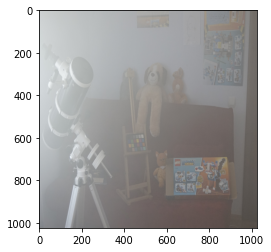

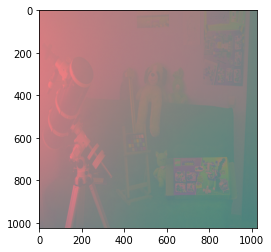

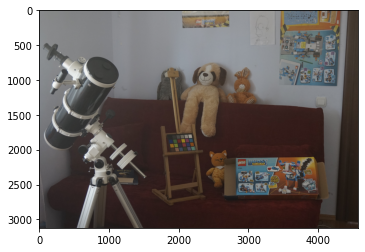

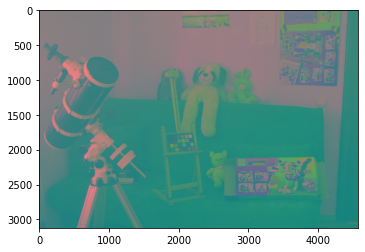

In [ ]:
image = cv2.imread(x_test[28])
image = cv2.resize(image,(1024,1024))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imsave('ip.png',image)
plt.show()
image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
plt.imshow(image)
plt.show()
    
mask = cv2.imread(y_test[28])
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2YCrCb)
plt.imshow(mask)
plt.show()

In [ ]:
network = torch.load('/content/drive/MyDrive/Haze weights/I-haze_YcBCR.pth')
net = DehazeModel()
net = nn.DataParallel(net, device_ids=[0])
net.to(device)
net.load_state_dict(network['weights'])
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

In [ ]:
val_ds = DehazeDataset(
        img_paths=x_test,
        mask_paths=y_test,
        a = False
    )

val_loader = DataLoader(
        val_ds,
        batch_size=1,
        num_workers=2,
        shuffle=False,
    )

In [ ]:
import torch.nn.functional as F9
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F9.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F9.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F9.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F9.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F9.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


import torchvision.transforms.functional as F6
def to_tensor(img):
    img_t = F6.to_tensor(img).float()
    return img_t

from tqdm import tqdm
imgs = []
ori = []
ori_ycbcr = []
pred_ycbcr = []
hp = []
lp = []
preds = []
def test(model, loader):
        l_test = []
        ps_test = []
        ss_test = []

        with torch.no_grad():
          model.eval()
          for i, data in tqdm(enumerate(loader)):
            x, y1, y2, y3 = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            pred1, pred2, pred3 = model(x) 

            imgs.append(x[0].detach().cpu())
            ori_ycbcr.append(y3[0].detach().cpu())
            pred_ycbcr.append(pred3[0].detach().cpu())
            hp.append(y1[0].detach().cpu())
            lp.append(y2[0].detach().cpu())


            y3 = y3.permute(0, 2, 3, 1)
            y3 = y3[0].cpu().detach().numpy()
            y3 = cv2.cvtColor(y3, cv2.COLOR_YCrCb2RGB)
            y3 = to_tensor(y3).unsqueeze(0).permute(0, 3, 1, 2)
            ori.append(y3[0].permute(0,2,1).detach().cpu())

            pred3 = pred3.permute(0, 2, 3, 1)
            pred3 = pred3[0].cpu().detach().numpy()
            pred3 = cv2.cvtColor(pred3, cv2.COLOR_YCrCb2RGB)
            pred3 = to_tensor(pred3).unsqueeze(0).permute(0, 3, 1, 2)
            preds.append(pred3[0].permute(0,2,1).detach().cpu())

            s=ssim(pred3, y3)
            ss_test.append(s)
            p=psnr(pred3, y3)
            ps_test.append(p)

        print('Val PSNR: ', sum(ps_test)/len(ps_test))
        print('Val SSIM: ', sum(ss_test)/len(ss_test))

test(model=net, loader=val_loader)
imgs = np.array(imgs)
ori = np.array(ori)
ori_ycbcr = np.array(ori_ycbcr)
pred_ycbcr = np.array(pred_ycbcr)
hp = np.array(hp)
lp = np.array(lp)
preds = np.array(preds)

30it [00:27,  1.08it/s]

Val PSNR:  17.72708777029347
Val SSIM:  tensor(0.8575)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: FutureWarning: The input object of type 'Tensor' is an array-like implementing on

In [ ]:
imgs[0].shape, ori[0].shape , ori_ycbcr[0].shape , pred_ycbcr[0].shape, hp[0].shape ,lp[0].shape ,preds [0].shape

(torch.Size([3, 1024, 1024]),
 torch.Size([1024, 1024, 3]),
 torch.Size([3, 1024, 1024]),
 torch.Size([3, 1024, 1024]),
 torch.Size([3, 1024, 1024]),
 torch.Size([1, 1024, 1024]),
 torch.Size([1024, 1024, 3]))

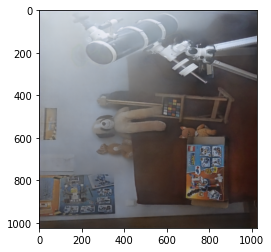

In [ ]:
a = a.numpy()
min_val = np.min(a)
max_val = np.max(a)
img_data_clamped = (a - min_val) / (max_val - min_val)
plt.imsave('/content/preds.png', img_data_clamped)
plt.imshow(img_data_clamped)

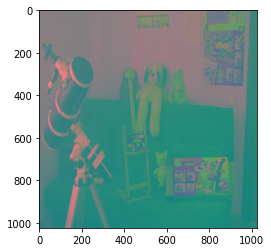

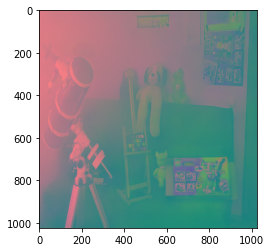

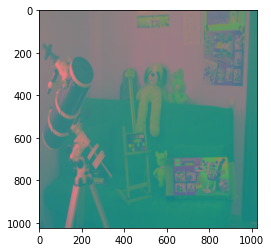

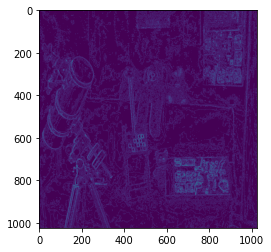

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: ignored

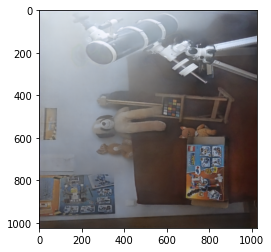

In [ ]:
# a = imgs[28].permute(1,2,0).detach().cpu()
# plt.imshow(a)
# plt.imsave('/content/ycbcr_input.png', a.numpy())
# plt.show()
# a = ori[28].detach().cpu()
# plt.imshow(a)
# plt.imsave('/content/rgb_ori.png', a.numpy())
# plt.show()
a = ori_ycbcr[28].permute(1,2,0).detach().cpu()
plt.imshow(a)
plt.imsave('/content/ori_ycbcr.png', a.numpy())
plt.show()
a = pred_ycbcr[28].permute(1,2,0).detach().cpu()
plt.imshow(a)
plt.imsave('/content/pred_ycbcr.png', a.numpy())
plt.show()
a = hp[28].permute(1,2,0).detach().cpu()
plt.imshow(a)
plt.imsave('/content/hp.png', a.numpy())
plt.show()
a = lp[28].permute(1,2,0).detach().cpu()
plt.imshow(a[:,:,0])
plt.imsave('/content/lp.png', a[:,:,0].numpy())
plt.show()
a = preds[28].detach().cpu()
plt.imshow(a)
plt.imsave('/content/preds.png', a.numpy())
plt.show()

In [ ]:
for i in range(imgs.shape[0]):
  print(i)
  plt.figure(figsize=(12,8))

  plt.subplot(221)
  plt.imshow(imgs[i][0].detach().cpu())
  plt.title('Hazy Image')
  plt.subplot(222)
  plt.imshow(ori[i][0].detach().cpu())
  plt.title('Groundtruth Image...')
  plt.subplot(223)
  plt.imshow(preds[i][0].detach().cpu())
  plt.title('Predicted Hazyfree Image')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(imgs.shape[0]):
  print(i)
  plt.figure(figsize=(12,8))
cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
  plt.subplot(221)
  plt.imshow((imgs[i][0].detach().cpu()))
  plt.title('Hazy Image')
  plt.subplot(222)
  plt.imshow(ori[i][0].detach().cpu())
  plt.title('Groundtruth Image...')
  plt.subplot(223)
  plt.imshow(preds[i][0].detach().cpu())
  plt.title('Predicted Hazyfree Image')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# /content/drive/MyDrive/Haze weights/ohaze_500.pth
# /content/drive/MyDrive/Haze weights/I_Haze.pth
# /content/drive/MyDrive/Haze weights/dense_haze.pth

In [ ]:
network = torch.load('/content/drive/MyDrive/Haze weights/ohaze_500.pth')
net = DehazeModel()
net = nn.DataParallel(net, device_ids=[0])
net.to(device)
net.load_state_dict(network['weights'])
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

In [ ]:
path = "/content/drive/Shareddrives/ALN Prediction/NEW_DATA/O HAZE/# O-HAZY NTIRE 2018/hazy"
hdir = os.listdir(path)

In [ ]:
hdir = sorted(hdir)

In [ ]:
len(hdir)

45

In [ ]:
def prediction(model, image, patch_size):
    # segm_img = np.zeros(image.shape[:3])  #Array with zeros to be filled with segmented values
    # print(segm_img.shape)
    # patch_num=1
    # for i in range(0, image.shape[0], 512):   #Steps of 256
    #     for j in range(0, image.shape[1], 512):  #Steps of 256
    #         #print(i, j)
    #         single_patch = image[i:i+patch_size, j:j+patch_size]
    #         #print(single_patch.shape)
    #         single_patch_norm = np.array(single_patch)/255.0
    #         single_patch_shape = single_patch_norm.shape[:2]
    #         single_patch_input = np.expand_dims(single_patch_norm, 0)
    #         single_patch_input = single_patch_input.transpose(0, 3, 1, 2)
    #         single_patch_input = torch.Tensor(single_patch_input).cuda()
            

    #         single_patch_prediction = model(single_patch_input)[-1].clamp(0, 1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    #         single_patch_prediction = single_patch_prediction[0]
            

    #         segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
          
    #         # print("Finished processing patch number ", patch_num, " at position ", i,j)
    #         patch_num+=1
    image = np.expand_dims(image, 0)
    image = image.transpose(0, 3, 1, 2)
    image = torch.Tensor(image).cuda()
    # h,l,hf = model(image)
    # h = h.clamp(0, 1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    # l = l.clamp(0, 1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    # hf = hf.clamp(0, 1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    prediction = model(image)[-1].clamp(0, 1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    prediction = prediction[0]
    # h = h[0]
    # l = l[0]
    # hf = hf[0]
    return prediction

In [ ]:
# 3072, 3584 -> 512
count = 1
for i in hdir:
  img = cv2.imread(path + '/' + i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img = img.transpose(1,0,2)
  img = cv2.resize(img, (1024,1024))
  h = prediction(net, img, 512)
  # print(l.shape,h.shape,hf.shape)
  plt.imsave('/content/predicted/{}.png'.format(count), h)
  # plt.imsave('/content/Untitled Folder/bw/{}.png'.format(count), l[:,:,0],cmap='gray')
  # plt.imsave('/content/Untitled Folder/hf/{}.png'.format(count), hf)
  count += 1

In [ ]:
# 3072, 3584 -> 512
count = 1
for i in hdir:
  img = cv2.imread(path + '/' + i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # img = img.transpose(1,0,2)
  img = cv2.resize(img, (1024,1024))
  pred = prediction(net, img, 512)
  plt.imsave('/content/drive/Shareddrives/ALN Prediction/inference/predection/NH-HAZE/{}.png'.format(count), pred)
  count += 1

In [ ]:
#Dhaze
i = cv2.imread("/content/WhatsApp Image 2022-02-25 at 21.13.21.jpeg")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
# i = i.transpose(1,0,2)
i = cv2.resize(i, (512, 512))
plt.imshow(i)
plt.show()
i = cv2.imread("/content/1.png")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
plt.imshow(i)
plt.show()

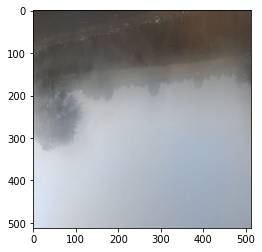

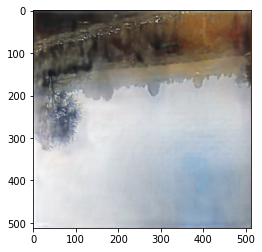

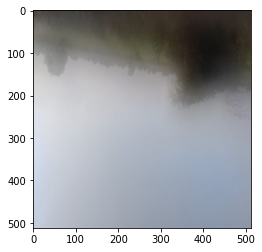

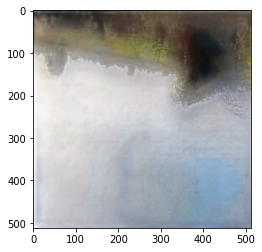

In [ ]:
#Ihaze
i = cv2.imread("/content/WhatsApp Image 2022-02-24 at 21.34.26.jpeg")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
i = i.transpose(1,0,2)
i = cv2.resize(i, (512, 512))
plt.imshow(i)
plt.show()
i = cv2.imread("/content/1.png")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
plt.imshow(i)
plt.show()

i = cv2.imread("/content/WhatsApp Image 2022-02-24 at 21.34.40.jpeg")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
i = i.transpose(1,0,2)
i = cv2.resize(i, (512, 512))
plt.imshow(i)
plt.show()
i = cv2.imread("/content/2.png")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
plt.imshow(i)
plt.show()

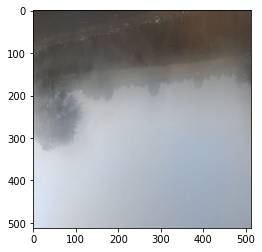

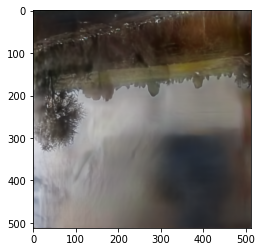

In [ ]:
#Ohaze
i = cv2.imread("/content/WhatsApp Image 2022-02-24 at 21.34.26.jpeg")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
i = i.transpose(1,0,2)
i = cv2.resize(i, (512, 512))
plt.imshow(i)
plt.show()
i = cv2.imread("/content/1.png")
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
plt.imshow(i)
plt.show()

# O haze

In [ ]:
x_val = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/O HAZE/WTHOUT RESIZE/VAL/HAZY/*.png')
y_val = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/O HAZE/WTHOUT RESIZE/VAL/GT/*.png')
x_test = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/O HAZE/WTHOUT RESIZE/TEST/HAZY/*.png')
y_test = glob.glob('/content/drive/Shareddrives/ALN Prediction/NEW_DATA/O HAZE/WTHOUT RESIZE/TEST/GT/*.png')

x_val = sorted(x_val)
y_val = sorted(y_val)
x_test = sorted(x_test)
y_test = sorted(y_test)

print(len(x_val), len(x_test), len(y_val), len(y_test))

243 246 243 246


In [ ]:
network = torch.load('/content/drive/MyDrive/Haze weights/dense_haze.pth')
net = DehazeModel()
net = nn.DataParallel(net, device_ids=[0])
net.to(device)
net.load_state_dict(network['weights'])
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

In [ ]:
val_ds = DehazeDataset(
        img_paths=x_val,
        mask_paths=y_val,
        a = False
    )

val_loader = DataLoader(
        val_ds,
        batch_size=1,
        num_workers=2,
        shuffle=False,
    )

In [ ]:
from tqdm import tqdm
imgs = []
ori = []
preds = []
def test(model, loader):
        l_test = []
        ps_test = []
        ss_test = []

        with torch.no_grad():
          model.eval()
          for i, data in tqdm(enumerate(loader)):
            x, y1, y2, y3 = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            pred1, pred2, pred3 = model(x) 
            s=ssim(pred3, y3)
            ss_test.append(s)
            p=ssim(pred3, y3)
            ps_test.append(p)
            imgs.append(x.permute(0,2,3,1))
            ori.append(y3.permute(0,2,3,1))
            preds.append(pred3.permute(0,2,3,1))
        print('Val PSNR: ', sum(ps_test)/len(ps_test))

test(model=net, loader=val_loader)

In [ ]:
for i in range(imgs.shape[0]):
  print(i)
  plt.figure(figsize=(12,8))

  plt.subplot(221)
  plt.imshow(imgs[i][0].detach().cpu())
  plt.title('Hazy Image')
  plt.subplot(222)
  plt.imshow(ori[i][0].detach().cpu())
  plt.title('Groundtruth Image...')
  plt.subplot(223)
  plt.imshow(preds[i][0].detach().cpu())
  plt.title('Predicted Hazyfree Image')
  plt.show()

In [ ]:
test_ds = DehazeDataset(
        img_paths=x_test,
        mask_paths=y_test,
        a = False
    )

test_loader = DataLoader(
        test_ds,
        batch_size=1,
        num_workers=2,
        shuffle=False,
    )

In [ ]:
from tqdm import tqdm
imgs = []
ori = []
preds = []
def test(model, loader):
        l_test = []
        ps_test = []
        ss_test = []

        with torch.no_grad():
          model.eval()
          for i, data in tqdm(enumerate(loader)):
            x, y1, y2, y3 = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            pred1, pred2, pred3 = model(x) 
            s=ssim(pred3, y3)
            ss_test.append(s)
            p=ssim(pred3, y3)
            ps_test.append(p)
            imgs.append(x.permute(0,2,3,1))
            ori.append(y3.permute(0,2,3,1))
            preds.append(pred3.permute(0,2,3,1))
        print('Test PSNR: ', sum(ps_test)/len(ps_test))

test(model=net, loader=val_loader)

In [ ]:
for i in range(imgs.shape[0]):
  print(i)
  plt.figure(figsize=(12,8))

  plt.subplot(221)
  plt.imshow(imgs[i][0].detach().cpu())
  plt.title('Hazy Image')
  plt.subplot(222)
  plt.imshow(ori[i][0].detach().cpu())
  plt.title('Groundtruth Image...')
  plt.subplot(223)
  plt.imshow(preds[i][0].detach().cpu())
  plt.title('Predicted Hazyfree Image')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.